In [1]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

import utils as u
from models import raw
from steps import preprocess
from visualization import papermode

papermode(plt, size=12)


In [2]:
def abbrange(letter:str, a:int, b:int)->Tuple[str]:
    return (f"{letter}{i:02}" for i in range(a,b))

In [3]:
d_abbrs = (*abbrange("D", 1, 7), "D09", "D11", "D12", "D13", "D14", "D16", *abbrange("D", 18, 23))
m_abbrs = abbrange("M", 1, 8)
# p_abbrs = (*abbrange("P", 1, 5), *abbrange("P", 6, 12))
r_abbrs = ("R02", "R03", "R09")
s_abbrs = (*abbrange("S", 1, 11), "S21", "S22", "S23", "S28", "S29", "S30", "S31")
t_abbrs = ("TB",)

abbrs = (
    *d_abbrs,
    *m_abbrs,
    # *p_abbrs,
    *r_abbrs,
    *s_abbrs,
    # *t_abbrs,
)

colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}

power_colors = {
    "Total power": "xkcd:electric blue",
    "Motion power": "xkcd:vermillion"
}

def add_terrain_legend(mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure]):
    legend_handles = [mpatches.Patch(color=col, label=lab) for lab, col in colors.items()]
    mpl_elem.legend(
        handles=legend_handles, ncol=len(colors), bbox_to_anchor=(0.5, -0.03), loc="upper center", title="Terrain"
    )

def add_power_legend(mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure]):
    legend_handles = [mpatches.Patch(color=col, label=lab) for lab, col in power_colors.items()]
    mpl_elem.legend(
        handles=legend_handles, ncol=len(colors), title="Power values"
    )


In [4]:
terrains = {a: u.get_terrain(a) for a in abbrs}
terrain_abbrs = {}
for abbr, terr in terrains.items():
    terrain_abbrs.setdefault(terr, []).append(abbr)

In [5]:
dfs = {}
pbar = tqdm(abbrs)
for abbr in pbar:
    pbar.set_description(abbr)
    preprocess(abbr, verbose=False)
    raw_df = raw.raw(abbr, verbose=False);
    dfs[abbr] = raw_df


S31: 100%|██████████| 44/44 [01:03<00:00,  1.45s/it]


In [6]:
terr_dfs = {t: [dfs[t_abbr] for t_abbr in t_abbrs] for t, t_abbrs in terrain_abbrs.items()}
terr_concat_dfs = {t: pd.concat(t_abbrs, ignore_index=True) for t, t_abbrs in terr_dfs.items()}
terr_pmotion = {t: t_df.P_motion.values for t, t_df in terr_concat_dfs.items()}
terr_ptotal = {t: t_df.P_total.values for t, t_df in terr_concat_dfs.items()}


In [7]:
for t, pmotion in terr_pmotion.items():
    print(t, pmotion.shape)
for t, ptotal in terr_ptotal.items():
    print(t, ptotal.shape)

till (1280,)
vegetal (2671,)
snow (8924,)
asphalt (4101,)
gravel (403,)
till (1280,)
vegetal (2671,)
snow (8924,)
asphalt (4101,)
gravel (403,)


In [8]:
model_name = raw.__MODEL_NAME__.lower()
figdir = u.get_figdir("summary", subdir=model_name)
model_name = raw.__MODEL_NAME__.title()


In [9]:
terr_labels = terr_pmotion.keys()
pmotion_data = terr_pmotion.values()
ptotal_data = terr_ptotal.values()
x_pos = np.arange(len(terr_labels))
terr_colors = tuple(colors[terr] for terr in terr_labels)



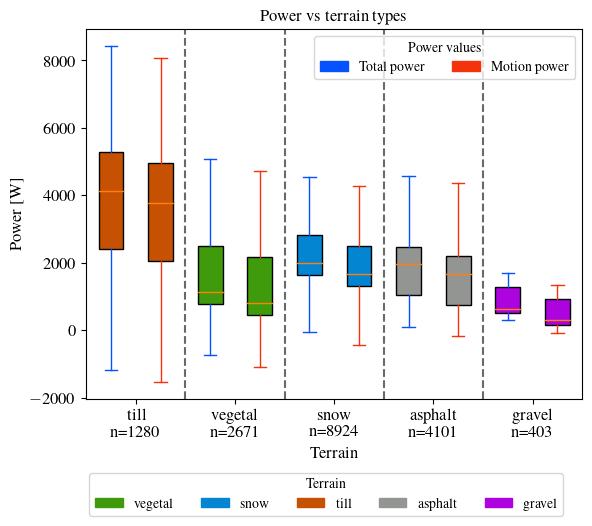

In [17]:
fig, ax = plt.subplots()

xpos_total = 2 * x_pos
xpos_motion = 2 * x_pos + 1
boxes_total = ax.boxplot(ptotal_data, showfliers=False, positions=xpos_total, patch_artist=True)
boxes_motion = ax.boxplot(pmotion_data, showfliers=False, positions=xpos_motion, patch_artist=True)

for box, col in zip(boxes_total["boxes"], terr_colors):
    box.set_facecolor(col)
for box, col in zip(boxes_motion["boxes"], terr_colors):
    box.set_facecolor(col)

for whisk in boxes_total["whiskers"]:
    whisk.set_color("xkcd:electric blue")
for elem in boxes_total["caps"]:
    elem.set_color("xkcd:electric blue")
for whisk in boxes_motion["whiskers"]:
    whisk.set_color("xkcd:vermillion")
for elem in boxes_motion["caps"]:
    elem.set_color("xkcd:vermillion")


label_pos = 2 * x_pos + 0.5
ax.set_xticks(label_pos)
ptot_lens = [ptot.size for ptot in ptotal_data]
labels = [f"{lab}\nn={n}" for lab, n in zip(terr_labels, ptot_lens)]
ax.set_xticklabels(labels)

dividers = 2 * x_pos[1:] - 0.5
for div in dividers:
    ax.axvline(x=div, linestyle="dashed", color="dimgray")


add_terrain_legend(fig)
add_power_legend(ax)

ax.set_ylabel("Power [W]")
ax.set_xlabel("Terrain")

ax.set_title("Power vs terrain types")
fig.savefig(figdir / f"{''.join(abbrs)}_terrain_powertotal_motion_box.jpg", bbox_inches="tight")
